In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import reduce

sys.path.insert(0, 'C:/Users/Bin/Desktop/Thesis/code')
from Conf_EncDecAD_KDD99 import Conf_EncDecAD_KDD99
from EncDecAD import EncDecAD

In [2]:
# Configuration 

data_root = "C:/Users/Bin/Documents/Datasets/KDD99/6_subsets_win/"
conf = Conf_EncDecAD_KDD99(data_root)
#[sn_list, va_list, vn1_list, vn2_list, tn_list, ta_list] = conf.data_list

#p_input = conf.p_input
#p_inputs = conf.p_inputs



batch_num = conf.batch_num
hidden_num = conf.hidden_num
step_num = conf.step_num
elem_num = conf.elem_num

iteration = conf.iteration
modelpath_root = conf.modelpath_root
modelpath = conf.modelpath
decode_without_input = conf.decode_without_input


 

# Training

is training
not training
iter 1: 4.11533
iter 2: 3.03944
iter 3: 2.99884
iter 4: 2.21775
iter 5: 2.23574
iter 6: 1.67834
iter 7: 1.65153
iter 8: 1.23238
iter 9: 1.10566
iter 10: 0.759089
iter 11: 0.68797
iter 12: 0.516608
iter 13: 0.496845
iter 14: 0.48323
iter 15: 0.412993
iter 16: 0.394626
iter 17: 0.31477
iter 18: 0.288718
iter 19: 0.280516
iter 20: 0.250336
iter 21: 0.234123
iter 22: 0.216068
iter 23: 0.221551
iter 24: 0.189942
iter 25: 0.217475
iter 26: 0.175929
iter 27: 0.184159
iter 28: 0.157962
iter 29: 0.149016
iter 30: 0.145306
iter 31: 0.151289
iter 32: 0.149986
iter 33: 0.141048
iter 34: 0.134575
iter 35: 0.138368
iter 36: 0.120327
iter 37: 0.116637
iter 38: 0.11716
iter 39: 0.111494
iter 40: 0.116958
iter 41: 0.106457
iter 42: 0.103423
iter 43: 0.102637
iter 44: 0.100256
iter 45: 0.101013
iter 46: 0.0962831
iter 47: 0.0948995
iter 48: 0.0913194
iter 49: 0.103274
iter 50: 0.100426
iter 51: 0.094291
iter 52: 0.0872027
iter 53: 0.0851727
iter 54: 0.0862976
iter 55: 0.0783277


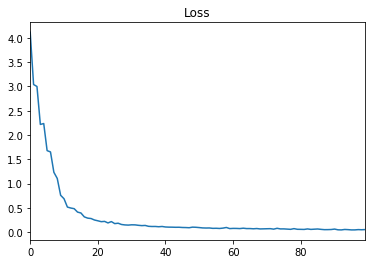

In [3]:

p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num),name = "p_input")
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]

p_is_training = tf.placeholder(tf.bool)

#is_training = tf.constant(False,name="is_training")
ae = EncDecAD(hidden_num, p_inputs, p_is_training , decode_without_input=False)

with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    loss = []
    for i in range(iteration):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(conf.sn_list)-1)
            sub = conf.sn_list[ind]
            data.append(sub)
        data = np.array(data)
        (loss_val, _) = sess.run([ae.loss, ae.train], {p_input: data,p_is_training : True})
        loss.append(loss_val)
        print('iter %d:' % (i + 1), loss_val)
    pd.Series(loss).plot(title="Loss")

    save_path = saver.save(sess, modelpath)
    print("Model saved in file: %s" % save_path)

# Calculate parameters using Vn1 dataset 

In [3]:
from Parameter_helper import Parameter_Helper

para = Parameter_Helper(conf)

mu, sigma = para.mu_and_sigma()

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/52test/LSTMAutoencoder_kdd99_v1.ckpt
Model restored.
Initialized
Got parameters mu and sigma.


# Calculate anomaly score, get threshold t using Vn2 and Va dataset.

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/52test/LSTMAutoencoder_kdd99_v1.ckpt
Finished
Threshold:  0.154171836744


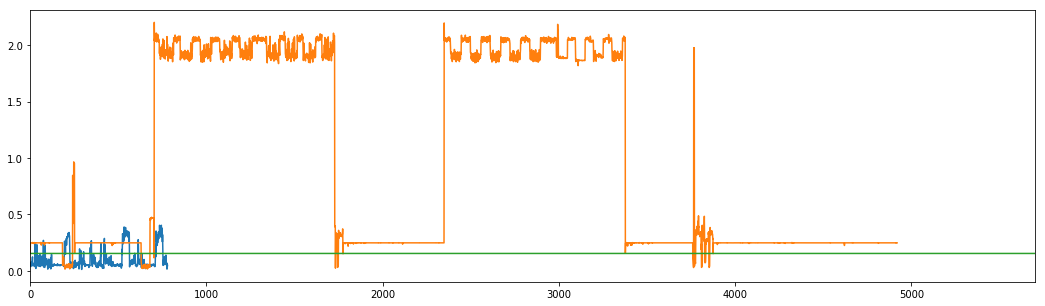

In [4]:
threshold = para.get_threshold(mu,sigma)

# test

In [6]:
with tf.Session() as sess:
    saver.restore(sess, modelpath)  # decode_without_input=True, iter=5000
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    n_in = []
    n_out = []
    a_in = []
    a_out = []
    
    for count in range(len(tn_list)//batch_num):
        normal_sub = np.array(tn_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        n_in.append(input_n)
        n_out.append(output_n)
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        err_n = err_n.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(ta_list)//batch_num):
        abnormal_sub = np.array(ta_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        a_in.append(input_a)
        a_out.append(output_a)
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        err_a = err_a.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Predict result :')

    pd.Series(normal_score).plot(label="normal_score",figsize=(18,5))
    pd.Series(abnormal_score).plot(label="abnormal_score")
    bar = threshold*np.ones(len(normal_score)+len(abnormal_score))
    pd.Series(bar).plot(label="threshold")

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/52test/LSTMAutoencoder_kdd99_v1.ckpt
Model restored.
Initialized


NameError: name 'tn_list' is not defined

# Evaluation

In [ ]:
beta = 0.5
tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
fp = len(abnormal_score)-tp
fn = np.array(normal_score)[np.array(normal_score)>threshold].size
tn = len(normal_score)- fn
P = tp/(tp+fp)
R = tp/(tp+fn)
fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
fbeta

In [ ]:
print(tp,fp,tn,fn,P,R)

In [ ]:
tp/fp